In [2]:
!git clone https://github.com/mohammadataei93/Algorithmic-Trading-.git

fatal: destination path 'Algorithmic-Trading-' already exists and is not an empty directory.


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib
!pip install zigzag
!pip install --upgrade mplfinance
!pip install yfinance
!pip install git+https://github.com/yhilpisch/tpqoa.git

In [4]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import datetime
from zigzag import *
import talib as ta
import mplfinance as mpf
from scipy.signal import argrelextrema
import pywt
from statsmodels.robust import mad
import tpqoa
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data 

we can fill the 'data' with each instrument or timeframe that we need

## BTC

this function get 1min data and return a dataframe with desired timeframe

In [4]:
def build_data(data , timeframe):
  dataframe = data.groupby(pd.Grouper(key='Date', freq=timeframe)).first().reset_index()
  dataframe['Open'] = data.groupby(pd.Grouper(key='Date', freq=timeframe)).first().reset_index()['Open']
  dataframe['Close'] = data.groupby(pd.Grouper(key='Date', freq=timeframe)).last().reset_index()['Close']
  dataframe['High'] = data.groupby(pd.Grouper(key='Date', freq=timeframe)).max().reset_index()['High']
  dataframe['Low'] = data.groupby(pd.Grouper(key='Date', freq=timeframe)).min().reset_index()['Low']
  dataframe['Volume'] = data.groupby(pd.Grouper(key='Date', freq=timeframe)).sum().reset_index()['Volume']
  return dataframe

get raw file of 1min data from google drive and preprocess it 

In [6]:
pd_data = pd.read_csv('/content/Algorithmic-Trading-/Data/BTCUSD(M1).csv')
pd_data = pd_data.loc[::-1] 
pd_data['Date'] = pd_data['date'].apply(lambda x: datetime.datetime.strptime(x , '%m/%d/%Y %H:%M'))
pd_data = pd_data.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','Volume BTC':'Volume'})
pd_data = pd_data[['Date','Open','High','Low','Close','Volume']]
pd_data.index = range(len(pd_data))

data = build_data(pd_data,'1h')
data.index = data.Date
data

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2019-09-20 04:00:00,2019-09-20 04:00:00,10222.44,10222.92,10198.27,10198.97,224.646000
2019-09-20 05:00:00,2019-09-20 05:00:00,10198.37,10202.68,10160.35,10161.05,1022.679000
2019-09-20 06:00:00,2019-09-20 06:00:00,10161.66,10191.40,10148.99,10168.30,998.575000
2019-09-20 07:00:00,2019-09-20 07:00:00,10169.40,10185.93,10150.42,10156.45,803.832000
2019-09-20 08:00:00,2019-09-20 08:00:00,10156.11,10187.10,10128.51,10139.58,932.418000
...,...,...,...,...,...,...
2021-09-20 21:00:00,2021-09-20 21:00:00,43545.85,43913.83,43426.62,43516.86,1184.124890
2021-09-20 22:00:00,2021-09-20 22:00:00,43516.87,43940.00,43043.16,43343.03,2070.266070
2021-09-20 23:00:00,2021-09-20 23:00:00,43343.02,43640.00,42551.11,43015.62,3700.142680


## ETH H1

In [6]:
# get h1 eth data from google drive and preprocess it
pd_data = pd.read_csv('/content/Algorithmic-Trading-/Data/ETHUSDT(H1).csv')
pd_data = pd_data.drop(['Open','Close'] , axis = 1)
pd_data = pd_data.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close'})
pd_data['Date'] = pd_data['time'].apply(lambda x : datetime.datetime.fromtimestamp(x))
pd_data = pd_data[['Date','Open','High','Low','Close','Volume']]
data = pd_data.copy()
data

,Date,Open,High,Low,Close,Volume
0,2019-01-01 00:00:00,131.45,132.22,131.01,131.82,12677.96176
1,2019-01-01 01:00:00,131.83,131.88,131.00,131.14,9541.84565
2,2019-01-01 02:00:00,131.19,131.34,130.00,130.72,12039.04136
3,2019-01-01 03:00:00,130.72,131.47,130.71,131.32,6320.30743
4,2019-01-01 04:00:00,131.31,134.00,131.30,132.35,29214.64195
...,...,...,...,...,...,...
23736,2021-09-18 11:00:00,3523.24,3536.41,3489.71,3496.50,11867.58800
23737,2021-09-18 12:00:00,3496.51,3518.23,3483.54,3488.48,17310.14510
23738,2021-09-18 13:00:00,3488.25,3507.00,3464.44,3481.50,12975.42900
23739,2021-09-18 14:00:00,3481.33,3492.13,3470.35,3481.20,10199.64770


In [8]:
data = yf.download(tickers='BTC-USD', period = '22h', interval = '15m')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-11-14 17:30:00+00:00,63708.746094,63776.789062,63663.621094,63776.789062,63776.789062,29732864
2021-11-14 17:45:00+00:00,63794.722656,64196.296875,63794.722656,64196.296875,64196.296875,192212992
2021-11-14 18:00:00+00:00,64174.121094,64390.355469,64174.121094,64224.886719,64224.886719,76044288
2021-11-14 18:15:00+00:00,64150.570312,64150.570312,63843.648438,64016.066406,64016.066406,43890688
2021-11-14 18:30:00+00:00,63979.945312,64022.320312,63927.402344,63931.187500,63931.187500,0
...,...,...,...,...,...,...
2021-11-15 13:45:00+00:00,65470.332031,65572.109375,65460.890625,65512.042969,65512.042969,118444032
2021-11-15 14:00:00+00:00,65530.921875,65530.921875,65333.546875,65333.546875,65333.546875,44544000
2021-11-15 14:15:00+00:00,65303.339844,65361.652344,65088.648438,65201.640625,65201.640625,152074240


## FOREX

get FX(EUR/USD) data from OANDA api

In [ ]:
api = tpqoa.tpqoa('/content/drive/MyDrive/Proj/oanda.cfg')
instrument = 'EUR_USD'
start = '2020-01-01'
end = '2021-01-01'
granularity = 'H1'
price = 'M'
data = api.get_history(instrument, start, end, granularity, price , localize=False)
data = data.drop(['complete'] , axis=1)
data = data.rename(columns={'o':'Open' , 'c':'Close','h': 'High','l':'Low','volume':'Volume'})
data['Date'] = data.index
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(str(x)[:-6], '%Y-%m-%d %H:%M:%S'))
data.index = data['Date']
data

,Open,High,Low,Close,Volume,Date
Date,,,,,,
2020-01-01 22:00:00,1.12124,1.12162,1.12124,1.12152,74,2020-01-01 22:00:00
2020-01-01 23:00:00,1.12149,1.12224,1.12149,1.12189,266,2020-01-01 23:00:00
2020-01-02 00:00:00,1.12187,1.12192,1.12158,1.12184,114,2020-01-02 00:00:00
2020-01-02 01:00:00,1.12186,1.12246,1.12182,1.12209,219,2020-01-02 01:00:00
2020-01-02 02:00:00,1.12206,1.12247,1.12185,1.12224,137,2020-01-02 02:00:00
...,...,...,...,...,...,...
2020-12-31 17:00:00,1.22302,1.22348,1.22219,1.22253,3940,2020-12-31 17:00:00
2020-12-31 18:00:00,1.22254,1.22280,1.22151,1.22169,2522,2020-12-31 18:00:00
2020-12-31 19:00:00,1.22167,1.22230,1.22094,1.22100,2214,2020-12-31 19:00:00


## S&P500 Daily

In [9]:
# load the S&P500 daily data from google drive
pd_data = pd.read_csv('/content/Algorithmic-Trading-/Data/S&P500(D).csv')
pd_data['Date'] = pd_data['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
pd_data = pd_data.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close'})
pd_data = pd_data[['Date','Open','High','Low','Close']]
data = pd_data.copy()
data


,Date,Open,High,Low,Close
0,2014-02-19 14:30:00,1838.90,1847.50,1826.99,1828.75
1,2014-02-20 14:30:00,1829.24,1842.79,1824.58,1839.78
2,2014-02-21 14:30:00,1841.07,1846.13,1835.60,1836.25
3,2014-02-24 14:30:00,1836.78,1858.71,1836.78,1847.61
4,2014-02-25 14:30:00,1847.66,1852.91,1840.19,1845.12
...,...,...,...,...,...
1925,2021-10-11 13:30:00,4385.44,4415.88,4360.59,4361.20
1926,2021-10-12 13:30:00,4368.31,4374.89,4342.09,4350.64
1927,2021-10-13 13:30:00,4358.01,4372.87,4329.92,4363.79
1928,2021-10-14 13:30:00,4386.75,4439.73,4386.75,4438.25


# Backtesting Class

In [5]:
class Backtest():

    def __init__(self,
                 amount = 10000 ,
                 commission=0.0,
                 verbose=True ,
                 strategy = 'Divregence',
                 argrelextrema_order = 5 ,
                 divergence_threshold = 0,
                 use_martingale = False,
                 long_only = True,
                 sma = None,
                 **kwargs
                 ):
      

        #amount => the amount of money we want to invest in the market (it can be consider as $)
        #commission => the proportional commission took by brooker in each trade
        #verbose => show some extra information during execution
        #argrelextrema_order => this in the parameter for scipy peak finder indicating the points that considers in that procedure
        #divergence_threshold => divergence must have sharper slope to considers
        #use_martingale => True if we want the backtester to use martingale strategy in its trades
        #long_only = True if we want the backtester only perform long positions
        #strategy => 'Divergence' , 'EMA Breakout'

        self.initial_amount = amount
        self.amount = amount
        self.commission = commission
        self.units = 0
        self.position = 0
        self.verbose = verbose
        self.argrelextrema_order = argrelextrema_order 
        self.divergence = None
        self.divergence_threshold = divergence_threshold 
        self.use_martingale = use_martingale
        self.long_only = long_only
        self.data = None
        self.sma = sma
        self.strategy = strategy



        # function to round all amounts to 4 digit float
        self.rounder = lambda x:(np.floor(np.round(x,5) * 10000) / 10000)
        

        # dataframe to keep every time step pnl
        self.PnL = pd.DataFrame(columns=['Date','pnl'])
        self.open_position = None
        self.positions_info = []




    #this method get a dataframe and calculate all features and indicators that the backtester needs to perform a strategy
    def add_data(self , data):

      self.data = data.copy()
      self.data.index = self.data['Date']
      self.data['RSI'] = ta.RSI(self.data['Close'])
      self.data['MACD'],self.data['MACD_Signal'],self.data['MACD_Hist'] = ta.MACD(self.data['Close'])
      self.data['ATR'] = ta.ATR(self.data['High'],self.data['Low'],self.data['Close'])
      self.data['slowk'], self.data['slowd'] = ta.STOCH(self.data['High'],self.data['Low'],
                                                        self.data['Close'],fastk_period=5,slowk_period=3,slowd_period=3)
      if self.sma:
        self.sma_key = f'SMA{self.sma}'
        self.data[self.sma_key] = ta.SMA(self.data['Close'],self.sma)
      self.data['EMA50'] = ta.SMA(self.data['Close'],50)
      self.data.dropna(inplace = True)

    # plot any column of data
    def plot_data(self, cols='Close'):
        self.data[cols].plot(figsize=(10, 6))

    #return date and price of a certain bar (priceindex indicates the column to return)
    def get_date_price(self, bar , priceindex = 'Close'):
        date = str(self.data.index[bar])
        price = self.data[priceindex].iloc[bar]
        return date, price

    #Print out current cash balance info
    def print_balance(self, bar):
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')
  
    #calculate all the asset in a given bar
    def calculate_asset(self,bar):
        date, price = self.get_date_price(bar)
        self.asset = self.units * price + self.amount
        return self.asset

    #calculate and plot PNL 
    def calculate_PnL(self,dates,pnl,show = True):
        self.PnL['Date'] = dates
        self.PnL['pnl'] = pnl
        self.PnL.index = self.PnL['Date']
        self.PnL['pnl'].plot(figsize=(10, 6))

    #perform a long order 
    #this method can buy an instrument with a given amount or unit on any price
    def place_long_order(self, bar, amount=None , price = None):
        if price == None: date, price = self.get_date_price(bar)
        if self.amount == None : amount = self.amount

        amount = amount * (1 - self.commission)
        units = self.rounder(amount/price)
        self.amount -= (units * price * (1 + self.commission) ) 
        self.amount = self.rounder(self.amount)
        self.units += units
        if self.verbose:
          date , _ = self.get_date_price(bar)
          print(f'{date} | *****Long Order Executed***** buying {units} units at {price:.2f}')

    #close the opened long order in any price 
    def close_long_order(self,bar,price=None,units=None):

        if price == None: date, price = self.get_date_price(bar)
        self.amount +=  (units * price * (1 - self.commission) )
        self.amount = self.rounder(self.amount)
        self.units -= units
        if self.verbose:
            date , _ = self.get_date_price(bar)
            print(f'{date} | ^^^^^Long Order Closed^^^^^  selling {units} units at {price:.2f}')

    #perform a short order 
    #this method can sell an instrument with a given amount or unit on any price
    def place_short_order(self, bar, amount=None , price = None):
        if price == None: date, price = self.get_date_price(bar)
        if self.amount == None : amount = self.amount

        amount = amount * (1 - self.commission)
        units = self.rounder(amount/price)
        self.amount += (units * price * (1 - self.commission) ) 
        self.amount = self.rounder(self.amount)
        self.units -= units
        if self.verbose:
          date , _ = self.get_date_price(bar)
          print(f'{date} | *****Short Order Executed***** selling {units} units at {price:.2f}')

    #close the opened short order in any price
    def close_short_order(self,bar,price=None,units=None):

        if price == None: date, price = self.get_date_price(bar)
        self.amount -=  (units * price * (1 + self.commission) )
        self.amount = self.rounder(self.amount)
        self.units += units
        if self.verbose:
            date , _ = self.get_date_price(bar)
            print(f'{date} | ^^^^^Short Order Closed^^^^^  buying {units} units at {price:.2f}')

    #at the end of the backtesting close all the positions 
    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = 0
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
        print('Final balance   [$] {:.2f}'.format(self.amount))
        perf = ((self.amount ) /
                self.initial_amount )
        count ,avg_win , avg_lose = 0,0,0
        for pos in self.positions_info:
          if pos['Profit'] > 0 :
            count += 1
            avg_win += pos['Profit']
          if pos['Profit'] < 0 :
            avg_lose += pos['Profit']

        self.accuracy = count / len(self.positions_info)
        print('Net Performance [A] {:.2f}'.format(perf))
        print('Trades Executed [#] {}'.format(len(self.positions_info)))
        print('Accuracy        [%] {:.2f}'.format(self.accuracy * 100))
        print('Avg Win/Avg Lose   {:.2f}'.format( np.abs(avg_win / avg_lose)) )
        print('=' * 55)


    #this method find divergence in price and a given indicator 
    def divergence_detector(self, data , div):
      divergence = None
      peak = None
      price_data = data['Close'].values
      #using scipy package to find peaks in data 
      highs = argrelextrema(price_data , np.greater_equal, order=self.argrelextrema_order)[0]
      lows = argrelextrema(price_data , np.less_equal, order=self.argrelextrema_order)[0]
      #finding the kind of last peak and its previous peaks
      if highs[-1] > lows[-1]:
        peak = 'High'
        current_peak_idx = highs[-1]
        previous_peak_idx = highs[-2]
        reverse_peak_idx = lows[-1]
      else :
        peak = 'Low'
        current_peak_idx = lows[-1]
        previous_peak_idx = lows[-2]
        reverse_peak_idx = highs[-1]

      #keep the date of peaks that may make a divergence
      peak1 = data['Date'][current_peak_idx]
      peak2 = data['Date'][previous_peak_idx]
      peak_reverse = data['Date'][reverse_peak_idx]

      price = data['Close'].values
      indicator = data[div].values

      #set the threshold value for divergence detecting
      div_th_pos = 1 + self.divergence_threshold 
      div_th_neg = 1 - self.divergence_threshold 

      #conditions for divergence on price and macd histogram
      if div == 'MACD_Hist':
        if peak == 'High':
          if price[current_peak_idx] > div_th_pos*price[previous_peak_idx] and indicator[current_peak_idx] < indicator[previous_peak_idx] and \
                    data['MACD_Hist'][current_peak_idx] > 0 and data['MACD_Hist'][previous_peak_idx] > 0: 
            divergence = 'Bearish'
        if peak == 'Low':
          if price[current_peak_idx] < div_th_neg*price[previous_peak_idx] and indicator[current_peak_idx] > indicator[previous_peak_idx] and \
                    data['MACD_Hist'][current_peak_idx] < 0 and data['MACD_Hist'][previous_peak_idx] < 0:
            divergence = 'Bullish'
      #conditions for divergence on price and rsi or any other indicator
      else: 
        if peak == 'High':
          if price[current_peak_idx] > div_th_pos*price[previous_peak_idx] and indicator[current_peak_idx] < indicator[previous_peak_idx]:
            divergence = 'Bearish'
        if peak == 'Low':
          if price[current_peak_idx] < div_th_neg*price[previous_peak_idx] and indicator[current_peak_idx] > indicator[previous_peak_idx]:
            divergence = 'Bullish'

      return divergence , peak1 , peak2 , peak_reverse 

    #this method detect hidden divergence between price and any given indicator
    def hidden_divergence_detector(self, data , div):
      divergence = None
      peak = None
      price_data = data['Close'].values
      highs = argrelextrema(price_data , np.greater_equal, order=self.argrelextrema_order)[0]
      lows = argrelextrema(price_data , np.less_equal, order=self.argrelextrema_order)[0]
      if highs[-1] > lows[-1]:
        peak = 'High'
        current_peak_idx = highs[-1]
        previous_peak_idx = highs[-2]
        reverse_peak_idx = lows[-1]
      else :
        peak = 'Low'
        current_peak_idx = lows[-1]
        previous_peak_idx = lows[-2]
        reverse_peak_idx = highs[-1]

      peak1 = data['Date'][current_peak_idx]
      peak2 = data['Date'][previous_peak_idx]
      peak_reverse = data['Date'][reverse_peak_idx]


      price = data['Close'].values
      indicator = data[div].values

      if div == 'MACD_Hist':
        if peak == 'High':
          if price[current_peak_idx] < price[previous_peak_idx] and indicator[current_peak_idx] > indicator[previous_peak_idx] and \
                    data['MACD_Hist'][current_peak_idx] > 0 and data['MACD_Hist'][previous_peak_idx] > 0: 
            divergence = 'Bearish'
        if peak == 'Low':
          if price[current_peak_idx] > price[previous_peak_idx] and indicator[current_peak_idx] < indicator[previous_peak_idx] and \
                    data['MACD_Hist'][current_peak_idx] < 0 and data['MACD_Hist'][previous_peak_idx] < 0:
            divergence = 'Bullish'
      else: 
        if peak == 'High':
          if price[current_peak_idx] < price[previous_peak_idx] and indicator[current_peak_idx] > indicator[previous_peak_idx]:
            divergence = 'Bearish'
        if peak == 'Low':
          if price[current_peak_idx] > price[previous_peak_idx] and indicator[current_peak_idx] < indicator[previous_peak_idx]:
            divergence = 'Bullish'

      return divergence , peak1 , peak2 , peak_reverse 


    #return a signal when 3 simple moving averages be arranged in order
    def smasignal(self, data):
      sma20,sma50,sma100 = data['SMA20'],data['SMA50'],data['SMA100']
      condition1 = sma20 > sma50
      condition2 = sma50 > sma100
      if condition1[0] == True and all(condition1) and condition2[0]== True and all(condition2):
        return 'Bullish'
      if condition1[0] == False and all(condition1) and condition2[0]== False and all(condition2):
        return 'Bearish'
      return None

    # reurn a signal if price break the exponential moving avarage 
    def breakout_detector(self, data , mode='detecting'):
      price = data['Close'].values
      ema50= data['EMA50'].values
      if mode == 'detecting':
        if price[-2] < ema50[-2] and price[-1] > ema50[-1]:
          return 'Breakout'
        return None
      if mode == 'checking':
        if price[-1] < ema50[-1]:
          return 'Failed Breakout'
        return 'Breakout'


    #main function to run the ema brakout strategy
    def run_breakout(self , **kwargs):
        msg = f'\n\nRunning Strategy'
        msg += f'\nCommission Fee {self.commission}'
        print(msg)
        print('=' * 55)
        self.position = 0  # 0 if no position opened,1 when there is a open position
        self.amount = self.initial_amount #the money that we will have in any bar

        self.window = kwargs['window'] # window of historical data that we look at in each bar
        if 'found_risk' in kwargs: 
          self.found_risk = kwargs['found_risk'] #the portion of amount that we want to risk at any position
        else: self.found_risk = 0.02 

        self.state = 'Wait For Signal' # initial state of the strategy is to wait for a breakout signal
        self.data['long_position'] = np.nan
        self.data['short_position'] = np.nan
        
        # if we want the algorithm to perform its positions by martingale method
        if self.use_martingale:
          self.martingale = [1,2,4,8]
          self.slope = self.martingale[0]
          self.order_average = None

        self.initial_invest = None

        dates,pnl = [],[]
        position_id = 0
        counter = 0

        # main loop over all the data
        for bar in range(self.window , len(self.data)):

          data = self.data[bar - self.window : bar]  # split a window of last observed data
          
          if self.position != 0: self.follow_positions(bar) # if we are in a position the algorithm follow that with follow_position method

          if self.position == 0: # if we dont have any open position then go for it

            if self.state == 'Wait For Signal': # if we still dont get any signal keep detecting
              breakout = self.breakout_detector(data , 'detecting')
              # if we got a signal the we will wait for the confirmation
              if breakout:
                counter +=1 
                self.state = 'Wait For Confirmation'

            if self.state == 'Wait For Confirmation': # waitng for confirmation

              breakout = self.breakout_detector(data , 'checking') # breakout not failed

              if breakout == 'Breakout' and data['Close'][-1] > (2*data['ATR'][-1] + data['EMA50'][-1]): # condition to confirm the signal
                #perform a long position
                date , entering_price = self.get_date_price(bar)
                self.position = 'Long'
                sl,tp = self.place_sl_tp(bar)
                self.data['long_position'][bar] = 1 
                position_id += 1
                self.open_position = {'position_id':position_id,'Index':bar,'Date':date,
                                            'Position':'Long','EnteringPrice':entering_price,
                                            'TakeProfit':tp,'StopLoss':sl,
                                            'Profit':None}
                
                if self.use_martingale: # we go with 5 percent of our money if using martingale strategy
                  self.initial_invest =  self.amount * 0.05
                  self.place_long_order(bar, amount= self.initial_invest * self.slope) 
                
                else:
                  self.place_long_order(bar, amount= self.amount * self.found_risk) 
                
                self.order_average = entering_price 
                self.state = 'Wait For Signal' # reset the state
                if self.verbose:
                  print(f'{date} | Long position for {self.divergence} with Take Profit : {tp:.02f}')

              else : # duration of waiting between getting signal and its cofirmation
                counter += 1
                if counter > 4 :
                  counter = 0
                  self.state= 'Wait For Signal'


          date , price = self.get_date_price(bar)
          dates.append(date)
          pnl.append(self.calculate_asset(bar))

        self.close_out(bar) # at the end we close all the open positions
        self.calculate_PnL(dates , pnl) # calculate and plot PnL

    def run_divergence(self , **kwargs):
        msg = f'\n\nRunning Divergence Strategy'
        msg += f'\nCommission Fee {self.commission}'
        print(msg)
        print('=' * 55)
        self.position = 0 # 0 if no position opened,1 when there is a open position
        self.amount = self.initial_amount #the money that we will have in any bar

        self.window = kwargs['window'] # window of historical data that we look at in each bar
        self.div = kwargs['div']  # wich indicator we want to get divergence from
        if 'found_risk' in kwargs:
          self.found_risk = kwargs['found_risk']
        else: self.found_risk = 0.02 

        self.state = 'Wait For Signal' # initial state of the strategy is to wait for a breakout signal
        self.observed_divergence = None
        self.data['long_position'] = np.nan
        self.data['short_position'] = np.nan
        self.peak1 ,self.peak2 = None,None

        # if we want the algorithm to perform its positions by martingale method
        if self.use_martingale:
          self.martingale = [1,2,4,8]
          self.slope = self.martingale[0]
          self.order_average = None

        self.initial_invest = None

        dates,pnl = [],[]
        position_id = 0
        counter = 0

        # main loop over all the data
        for bar in range(self.window , len(self.data)):

          data = self.data[bar - self.window : bar]  # split a window of last observed data
          
          if self.position != 0: self.follow_positions(bar)  # if we are in a position the algorithm follow that with follow_position method

          if self.position == 0: # if we dont have any open position then go for it

            if self.state == 'Wait For Signal':  # if we still dont get any signal keep detecting
              # rsi_divergence,rsi_peak1,rsi_peak2,rsi_peak_reverse = self.divergence_detector(data , div = self.div)
              macd_divergence,macd_peak1,macd_peak2,macd_peak_reverse = self.divergence_detector(data , div = 'MACD_Hist') # detecting a divergence in macd histogram
              # if rsi_divergence:
              #   counter +=1
              #   self.observed_divergence = rsi_divergence
              #   self.peak1,self.peak2,self.peak_reverse  = rsi_peak1,rsi_peak2,rsi_peak_reverse 
              #   self.state = 'Wait For Confirmation'
              #   self.divergence = 'RSI'

              if macd_divergence: # if we got an divergence signal then change the state of the algorithm to waiting for confirmation
                counter +=1
                self.observed_divergence = macd_divergence
                self.peak1,self.peak2,self.peak_reverse  = macd_peak1,macd_peak2,macd_peak_reverse 
                self.state = 'Wait For Confirmation'
                self.divergence = 'MACD'

            if self.state == 'Wait For Confirmation': #if we got a signal

              if self.data['Close'][bar-1] > self.data[self.sma_key][bar-1] and self.observed_divergence == 'Bullish':  #conditions to confirm the signal and performing a buy position
                date , entering_price = self.get_date_price(bar)
                self.position = 'Long'
                sl,tp = self.place_sl_tp(bar)
                self.data['long_position'][bar] = 1 
                position_id += 1
                self.open_position = {'position_id':position_id,'Index':bar,'Date':date,
                                            'Position':'Long','EnteringPrice':entering_price,
                                            'TakeProfit':tp,'StopLoss':sl,'Peak1':self.peak1,
                                            'Peak2':self.peak2,'Divergence':self.divergence,
                                            'Profit':None}
                
                if self.use_martingale:  # we go with 5 percent of our money if using martingale strategy
                  self.initial_invest =  self.amount * 0.05
                  self.place_long_order(bar, amount= self.initial_invest * self.slope) 
                
                else:
                  self.place_long_order(bar, amount= self.amount * self.found_risk) 
                
                self.order_average = entering_price
                self.state = 'Wait For Signal'
                if self.verbose:
                  print(f'{date} | Long position for {self.divergence} | TP: {tp:.02f} , SL: {sl:.02f}')

              if not self.long_only and self.data['Close'][bar-1] < self.data[self.sma_key][bar-1] and self.observed_divergence == 'Bearish': #conditions to confirm the signal and performing a sell position
                date , entering_price = self.get_date_price(bar)
                self.position = 'Short'
                sl,tp = self.place_sl_tp(bar)
                self.data['short_position'][bar] = 1 
                position_id += 1
                self.open_position = {'position_id':position_id,'Index':bar,'Date':date,
                                            'Position':'Short','EnteringPrice':entering_price,
                                            'TakeProfit':tp,'StopLoss':sl,'Peak1':self.peak1,
                                            'Peak2':self.peak2,'Divergence':self.divergence,
                                            'Profit':None}
                
                if self.use_martingale:
                  self.initial_invest =  self.amount * 0.05
                  self.place_short_order(bar, amount= self.initial_invest * self.slope) 
                
                else:
                  self.place_short_order(bar, amount= self.amount * self.found_risk) 
                
                self.order_average = entering_price
                self.state = 'Wait For Signal'
                if self.verbose:
                  print(f'{date} | Short position for {self.divergence} | TP: {tp:.02f} , SL: {sl:.02f}')

              else :
                counter += 1
                if counter > 4 :
                  counter = 0
                  self.state = 'Wait For Signal'


          date , price = self.get_date_price(bar)
          dates.append(date)
          pnl.append(self.calculate_asset(bar))

        self.close_out(bar)  # at the end we close all the open positions
        self.calculate_PnL(dates , pnl) #calculate and plot PnL


    #run the desire algorithm
    def run(self,**kwargs): 
      if self.strategy == 'EMA Breakout':
        self.run_breakout(**kwargs)
      if self.strategy == 'Divergence':
        self.run_divergence(**kwargs)

    #place stop loss and take profit 
    #stop loss with 1ATR distance to the openning price
    #take profit 2*stoploss => risk/reward = 1/2
    def place_sl_tp(self , bar):
      sl,tp = None,None
      price = self.data['Close'][bar] 
      if self.position == 'Long':
        sl = price - self.data['ATR'][bar]
        tp = price + 2*(price - sl)
      if self.position == 'Short':
        sl = price + self.data['ATR'][bar]
        tp = price - 2*(sl - price)
      return sl,tp

    #this method follow positions by checking the touch of their stop loss or take profit at each bar 
    def follow_positions(self , bar):
      date , highprice = self.get_date_price(bar,priceindex ='High') # highest price in the current bar 
      date , lowprice = self.get_date_price(bar,priceindex ='Low')  # lowest price in the current bar 
      date , current_price = self.get_date_price(bar,priceindex ='Close') # close price of the current bar 
      entering_price = self.open_position['EnteringPrice'] # entering price of the current position
      tp = self.open_position['TakeProfit'] # take profit of the current position
      sl = self.open_position['StopLoss']   # stop loss of the current position

      # if we use martingale method in this points we add volume to our positions
      loss_point =  (entering_price - self.slope * 0.05 *entering_price)  if (self.use_martingale and self.position=='Long') else None 
      loss_point =  (entering_price + self.slope * 0.05 *entering_price)  if (self.use_martingale and self.position=='Short') else loss_point

      if self.open_position['Position'] == 'Long': # check the conditions for closing a long position

        if highprice > tp: # closing the long position when the take profit touches
          profit = (tp - self.order_average) * self.units
          self.close_long_order(bar, units=self.units , price = tp) # close the position and take our profit
          self.open_position['Profit'] = profit
          self.open_position['CloseDate'] = date
          self.positions_info.append(self.open_position) # save the information of closed position
          self.open_position = None
          self.position = 0 # now we dont longer have open position 
          self.slope = self.martingale[0] if self.use_martingale else None #reset the martingale order
          if self.verbose:
            print(f'{date} | $$$ Take Profit Activated at {tp:.2f} $$$')       
            print(f'{date} | Long Position Closed with {profit:.2f} Profit :)))')  
            print('=' * 55)
          return
          
        if (not self.use_martingale) and lowprice < sl: # closing the long position when the stop loss touches
          profit = (sl - self.order_average) * self.units 
          self.close_long_order(bar, units=self.units , price = sl)
          self.open_position['Profit'] = profit
          self.open_position['CloseDate'] = date
          self.positions_info.append(self.open_position)
          self.open_position = None
          self.position = 0
          self.slope = self.martingale[0] if self.use_martingale else None
          if self.verbose:
            print(f'{date} | !!! Stop Loss Activated at {sl:.2f} !!!')       
            print(f'{date} | Long Position Closed with {profit:.2f} Profit :)))')  
            print('=' * 55)
          return

        if self.use_martingale and lowprice < loss_point: #if we are using martingale and the loss point touches we will going to add volume
          if self.slope <= 4:
            print(' ' * 40)
            self.slope = self.martingale[self.martingale.index(self.slope) + 1] # doubles the martingale order
            # calculate the order avarage 
            self.order_average = (self.order_average * np.sum(self.martingale[:self.martingale.index(self.slope)])  + current_price * self.slope ) / np.sum(self.martingale[:self.martingale.index(self.slope) + 1])
            tp = 1.05 * self.order_average # place the take profit 5 percent over the order average
            self.open_position['TakeProfit'] = tp
            self.open_position[f'Slope{self.slope}_Date'] = date
            self.place_long_order(bar, amount= self.initial_invest * self.slope , price = loss_point) 
            print(f'{date} | Slope{self.slope} Activated , Take Profit Changed to : {tp:.02f}')
            print(' ' * 40)
          return

      if self.open_position['Position'] == 'Short': # check the conditions for closing a long position

        if lowprice < tp: # closing the short position when the take profit touches
          profit = (tp - self.order_average) * self.units
          self.close_short_order(bar, units=-self.units , price = tp)
          self.open_position['Profit'] = profit
          self.open_position['CloseDate'] = date
          self.positions_info.append(self.open_position)
          self.open_position = None
          self.position = 0
          self.slope = self.martingale[0] if self.use_martingale else None
          if self.verbose:
            print(f'{date} | $$$ Take Profit Activated at {tp:.2f} $$$')       
            print(f'{date} | Short Position Closed with {profit:.2f} Profit :)))')  
            print('=' * 55)
          return
          
        if highprice > sl: # closing the short position when the stop loss touches
          profit = (sl - self.order_average) * self.units 
          self.close_short_order(bar, units=-self.units , price = sl)
          self.open_position['Profit'] = profit
          self.open_position['CloseDate'] = date
          self.positions_info.append(self.open_position)
          self.open_position = None
          self.position = 0
          self.slope = self.martingale[0] if self.use_martingale else None
          if self.verbose:
            print(f'{date} | !!! Stop Loss Activated at {sl:.2f} !!!')       
            print(f'{date} | Short Position Closed with {profit:.2f} Profit :)))')  
            print('=' * 55)
          return

        if self.use_martingale and highprice > loss_point: #if we are using martingale and the loss point touches we will going to add volume
          if self.slope <= 4:
            print(' ' * 40)
            self.slope = self.martingale[self.martingale.index(self.slope) + 1]
            self.order_average = (self.order_average * np.sum(self.martingale[:self.martingale.index(self.slope)])  + current_price * self.slope ) / np.sum(self.martingale[:self.martingale.index(self.slope) + 1])
            tp = 1.05 * self.order_average 
            self.open_position['TakeProfit'] = tp
            self.open_position[f'Slope{self.slope}_Date'] = date
            self.place_long_order(bar, amount= self.initial_invest * self.slope , price = loss_point) 
            print(f'{date} | Slope{self.slope} Activated , Take Profit Changed to : {tp:.02f}')
            print(' ' * 40)
          return

      
    # show each position and the important features that make its status
    def illustrate_position(self,idx,forward_candles = 100):

      # load all the important information that we need from a position
      time_idx = self.positions_info[idx]['Index']
      position = self.positions_info[idx]['Position']
      date = self.positions_info[idx]['Date']
      takeprofit = self.positions_info[idx]['TakeProfit']
      stoploss = self.positions_info[idx]['StopLoss']
      profit = self.positions_info[idx]['Profit']
      id = self.positions_info[idx]['position_id']
      closedate = self.positions_info[idx]['CloseDate']
      peak1 = self.positions_info[idx]['Peak1']
      peak2 = self.positions_info[idx]['Peak2']
      divergence = self.positions_info[idx]['Divergence']

      print('=' * 55) 
      print(f'{date} |{position} Order Executed | ID:{id}')
      print(f'{closedate} |Profit : {profit:0.2f} ')
      # print(f'Divergence:{divergence}')
      print('=' * 55)

      # build two seperate data window right befor and after the entering price
      data1 = self.data[time_idx-self.window:time_idx]
      data2 = self.data[time_idx:time_idx+forward_candles]
      data = pd.DataFrame()
      dataclose = data1['Close'].values
      highs = argrelextrema(dataclose, np.greater_equal, order=self.argrelextrema_order)[0]
      lows = argrelextrema(dataclose, np.less_equal, order=self.argrelextrema_order)[0]
      peaks = [np.nan]*len(data1)
      peaks_macd ,peaks_rsi = [np.nan]*len(data1) , [np.nan]*len(data1)
      for h in highs:
        peaks[h] = data1['Close'][h]
        peaks_macd[h] = data1['MACD_Hist'][h]
        peaks_rsi[h] = data1['RSI'][h]
      for l in lows:
        peaks[l] = data1['Close'][l]
        peaks_macd[l] = data1['MACD_Hist'][l]
        peaks_rsi[l] = data1['RSI'][l]

      data1['pivots'] = peaks
      data1['pivots_macd'] , data1['pivots_rsi'] = peaks_macd , peaks_rsi
      data2['takeprofit'] = takeprofit
      data2['stoploss'] = stoploss
      data2['pivots'] = np.nan
      data2['pivots_macd'],data2['pivots_rsi'] = np.nan , np.nan
      data = pd.concat([data1,data2])
      data['signal'] = np.nan
      data['signal'][self.window] = data['Close'][self.window] 

      

      if self.positions_info[idx]['Position'] == 'Long':
        two_points = [( str(peak1) , float(data[data['Date'] == peak1]['Low'])),( str(peak2), float(data[data['Date'] == peak2]['Low']))]
      if self.positions_info[idx]['Position'] == 'Short':
        two_points = [( str(peak1) , float(data[data['Date'] == peak1]['High'])),( str(peak2), float(data[data['Date'] == peak2]['High']))]

      

      # subplots 
      ticker_name = 'Instrument'
      colors = ['g' if v >= 0 else 'r' for v in data["MACD_Hist"]]
      macd_plot = mpf.make_addplot(data["MACD"], panel=1, color='fuchsia', title="MACD" )
      macd_hist_plot = mpf.make_addplot(data["MACD_Hist"], type='bar', panel=1, color=colors) # color='dimgray'
      macd_hist_plot_pivot = mpf.make_addplot(data["pivots_macd"],type='scatter',markersize=10,marker='o' , panel=1 , color='black')
      # rsi_plot_pivot = mpf.make_addplot(data["pivots_rsi"],type='scatter',markersize=10,marker='o' , panel=2 , color='black')
      macd_signal_plot = mpf.make_addplot(data["MACD_Signal"], panel=1, color='b')
      if position == 'Long':
        signal_plot = mpf.make_addplot(data['signal'],type='scatter',markersize=150,marker='^' , panel=0)
      if position == 'Short':
        signal_plot = mpf.make_addplot(data['signal'],type='scatter',markersize=150,marker='v' , panel=0)
      pivot_plot = mpf.make_addplot(data['pivots'],type='scatter',markersize=10, marker='o' , panel=0 , color='black')
      # rsi_plot =  mpf.make_addplot(data['RSI'], panel=2, color='blue', title="RSI" )
      # ema_plot =  mpf.make_addplot(data['EMA50'], panel=0, color='blue')
      sma_plot =  mpf.make_addplot(data[self.sma_key], panel=0, color='blue')
      SL = mpf.make_addplot(data['stoploss'] ,panel=0,color='red')
      TP = mpf.make_addplot(data['takeprofit'] ,panel=0,color='green')

      # plot the main chart and give it the subplots

      plots = [signal_plot,TP,SL,macd_plot,macd_hist_plot,macd_signal_plot,macd_hist_plot_pivot,pivot_plot,sma_plot]
      mpf.plot(data ,
               type='candle',
               style='yahoo',
               figsize = (15,10) ,
               alines=[two_points,two_points] ,
               vlines=dict(vlines= [str(peak1),str(peak2)],linestyle='--', linewidths = (0.5,0.5) ),
               volume=False,
               volume_panel=3,
               addplot=plots, 
               title=f"\n{ticker_name}",
               ylabel='',
               ylabel_lower='')
      print(' ')
      print(' ')

    #plot the right place of the positions in a one look at all the data
    def plot(self):
      long_position_plot = mpf.make_addplot(self.data['long_position'],type='scatter',markersize=50,marker='o' , panel=0 , color = 'green' )
      # short_position_plot = mpf.make_addplot(self.data['short_position'],type='scatter',markersize=50,marker='o' , panel=0 , color = 'red')
      plots = [long_position_plot]
      
      mpf.plot(self.data ,
                type='candle',
                style='yahoo',
                figsize = (20,15) ,
                addplot=plots, 
                title=f"\nAll Data",
                ylabel='',
                ylabel_lower='')




Running Divergence Strategy
Commission Fee 0
2019-01-30 13:00:00 | *****Short Order Executed***** selling 91.9371 units at 108.77
2019-01-30 13:00:00 | Short position for MACD | TP: 106.35 , SL: 109.98
2019-01-31 00:00:00 | ^^^^^Short Order Closed^^^^^  buying 91.9371 units at 109.98
2019-01-31 00:00:00 | !!! Stop Loss Activated at 109.98 !!!
2019-01-31 00:00:00 | Short Position Closed with -111.40 Profit :)))
2019-01-31 01:00:00 | *****Short Order Executed***** selling 90.0847 units at 109.77
2019-01-31 01:00:00 | Short position for MACD | TP: 107.60 , SL: 110.86
2019-01-31 08:00:00 | ^^^^^Short Order Closed^^^^^  buying 90.0847 units at 107.60
2019-01-31 08:00:00 | $$$ Take Profit Activated at 107.60 $$$
2019-01-31 08:00:00 | Short Position Closed with 195.85 Profit :)))
2019-04-04 17:00:00 | *****Long Order Executed***** buying 65.5984 units at 153.73
2019-04-04 17:00:00 | Long position for MACD | TP: 160.52 , SL: 150.34
2019-04-05 04:00:00 | ^^^^^Long Order Closed^^^^^  selling 6

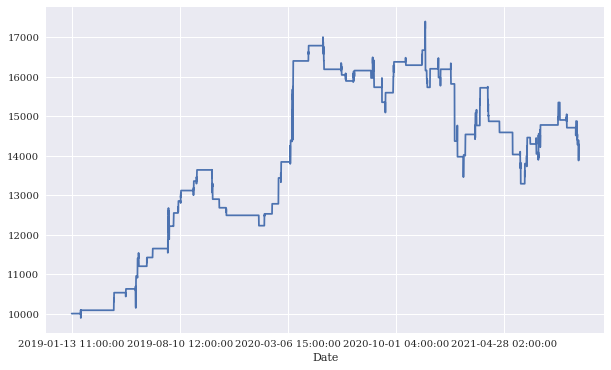

In [7]:
bt = Backtest(verbose=True,
              amount=10000,
              sma=200,
              commission = 0,
              strategy = 'Divergence',
              # strategy = 'EMA Breakout',
              use_martingale = False,
              divergence_threshold = 0.01,
              long_only = False
              )

bt.add_data(data)
bt.run(window = 100 , found_risk = 1,div='MACD_Hist')

2020-01-20 13:00:00 |Long Order Executed | ID:30
2020-01-20 22:00:00 |Profit : 299.53 


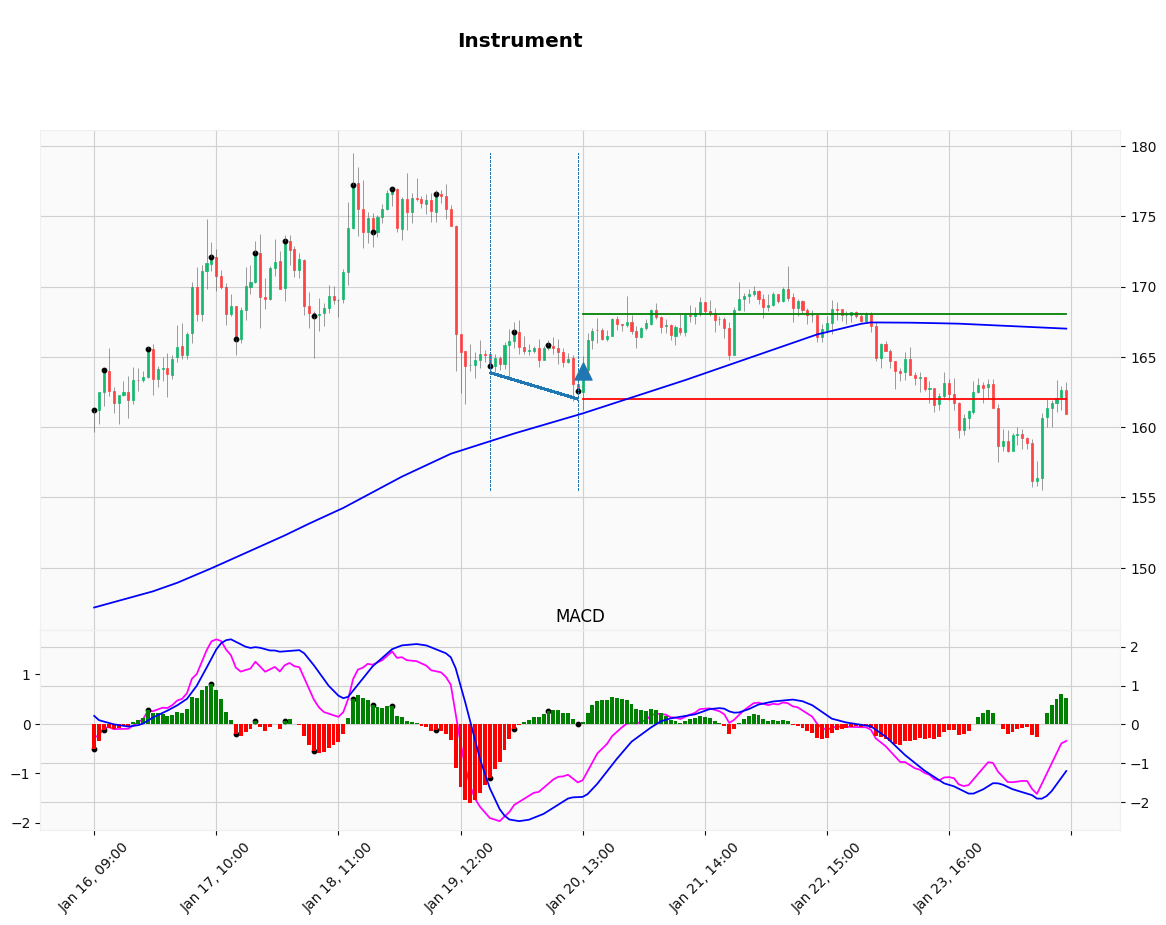

In [8]:
def show_positions(num_sample = 1):
  for i in range(num_sample):
    index = np.random.randint(0,len(bt.positions_info))
    bt.illustrate_position(index)

show_positions()